# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [3]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [ ]:
# Use this space for any additional import statements you need



In [6]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    num_total = len(tokens)
    num_unique = len(set(tokens))
    num_chars = sum(len(t) for t in tokens)
    lexical_diversity = num_unique / num_total if num_total > 0 else 0
    common = Counter(tokens).most_common(num_tokens)
    
    if verbose:
        print(f"Total tokens: {num_total}")
        print(f"Unique tokens: {num_unique}")
        print(f"Total characters: {num_chars}")
        print(f"Lexical diversity: {lexical_diversity:.3f}")
        print(f"Most common {num_tokens} tokens: {common}")

    return {
        "total_tokens": num_total,
        "unique_tokens": num_unique,
        "total_chars": num_chars,
        "lexical_diversity": lexical_diversity,
        "most_common": common,
    }


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    return [t for t in tokens if t.lower() not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return text.split()

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [7]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "data/M1 Results/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {
    'cher': {
        'twitter': 'cher_followers_data.txt',
        'lyrics': 'cher'   # this is a folder
    },
    'robyn': {
        'twitter': 'robynkonichiwa_followers_data.txt',
        'lyrics': 'robyn'  # this is a folder
    }
}


In [9]:
twitter_data = pd.read_csv(
    data_location + twitter_folder + artist_files['cher']['twitter'],
    sep="\t",
    quoting=3
)
twitter_data['artist'] = "cher"


In [20]:
twitter_data_2 = pd.read_csv(
    data_location + twitter_folder + artist_files['robyn']['twitter'],
    sep="\t",
    quoting=3
)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([twitter_data, twitter_data_2], ignore_index=True)
del twitter_data_2 



In [21]:
print(twitter_data['artist'].value_counts())


artist
cher     3994803
robyn     358372
Name: count, dtype: int64


In [22]:
def load_lyrics(artist):
    folder = os.path.join(data_location, lyrics_folder, artist_files[artist]['lyrics'])
    texts = []
    for file in os.listdir(folder):
        if file.endswith(".txt"):
            with open(os.path.join(folder, file), "r", encoding="utf-8") as f:
                texts.append(f.read())
    return texts

# Load lyrics for each artist
lyrics_cher = load_lyrics('cher')
lyrics_robyn = load_lyrics('robyn')

# Turn into DataFrames for consistency
lyrics_data = pd.DataFrame({
    "artist": ["cher"] * len(lyrics_cher) + ["robyn"] * len(lyrics_robyn),
    "lyrics": lyrics_cher + lyrics_robyn
})

lyrics_data.head()


,artist,lyrics
0,cher,"""Come And Stay With Me""\n\n\n\nI'll send away ..."
1,cher,"""Pirate""\n\n\n\nHe'll sail on with the summer ..."
2,cher,"""Stars""\n\n\n\nI was never one for saying what..."
3,cher,"""These Days""\n\n\n\nWell I've been out walking..."
4,cher,"""Love So High""\n\n\n\nEvery morning I would wa..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [23]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

lyrics_pipeline = [remove_punctuation, str.lower, tokenize, remove_stop]
twitter_pipeline = [str.lower, tokenize, remove_stop]  # keep hashtags + emojis

# Apply to lyrics
lyrics_data["tokens"] = lyrics_data["lyrics"].apply(lambda x: prepare(x, pipeline=lyrics_pipeline))
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

# Apply to twitter
twitter_data["tokens"] = twitter_data["description"].apply(lambda x: prepare(x, pipeline=twitter_pipeline))
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)


In [24]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [25]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1143282,cher,❤️,[❤️]
303323,cher,🤡❣️👿,[🤡❣️👿]
1219949,cher,"""Run mad as often as you choose but do not fai...","[""run, mad, often, choose, faint.""-jane, auste..."
2817027,cher,Music💕Animals💕🦄🦋🌈,[music💕animals💕🦄🦋🌈]
119446,cher,Blessed mama X2 👩‍👧‍👧 proudly married ✨👮‍♀️ GO...,"[blessed, mama, x2, 👩‍👧‍👧, proudly, married, ✨..."
2760366,cher,26 mom of 3 pits 🤟🏻🐶 🧜🏻‍♀️. 🦋 RIP mamma 9-25-17,"[26, mom, 3, pits, 🤟🏻🐶, 🧜🏻‍♀️., 🦋, rip, mamma,..."
908054,cher,novo twitter não tenho assunto mais tenho inte...,"[novo, twitter, não, tenho, assunto, mais, ten..."
179231,cher,writer. dog mom. science 💚 she/her,"[writer., dog, mom., science, 💚, she/her]"
522446,cher,I have Big heart know myself well boundaries i...,"[big, heart, know, well, boundaries, place, wi..."
982299,cher,Positivity is finally what’s in my life withou...,"[positivity, finally, what’s, life, without, n..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: There are a few different processing steps to improve tokenization that could occurr here. One example would be to remove contractions.  Depending on the type of analysis separating contractions into their full word structure may be helpful.  Also, further stemming could be applied where all tense and possesive versions for example could be reduced into one primary state of the word. Additional custom stopword configuration to reduce or remove words that don't provide any valuable context. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [26]:
# your code here
print("Cher Lyrics")
cher_lyrics_tokens = [tok for tokens in lyrics_data[lyrics_data['artist'] == 'cher']['tokens'] for tok in tokens]
descriptive_stats(cher_lyrics_tokens)

print("\nRobyn Lyrics")
robyn_lyrics_tokens = [tok for tokens in lyrics_data[lyrics_data['artist'] == 'robyn']['tokens'] for tok in tokens]
descriptive_stats(robyn_lyrics_tokens)


Cher Lyrics
Total tokens: 35916
Unique tokens: 3703
Total characters: 172634
Lexical diversity: 0.103
Most common 5 tokens: [('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333)]

Robyn Lyrics
Total tokens: 15227
Unique tokens: 2156
Total characters: 73787
Lexical diversity: 0.142
Most common 5 tokens: [('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 251)]


{'total_tokens': 15227,
 'unique_tokens': 2156,
 'total_chars': 73787,
 'lexical_diversity': 0.14159059565245943,
 'most_common': [('know', 308),
  ('dont', 301),
  ('im', 299),
  ('love', 275),
  ('got', 251)]}

Q: what observations do you make about these data? 

A: Cher's data set has many more tokens indicating that the data set is larger.  The lexical diversity in Cher's set is lower than Robyns, which means she reuses more words than Robyn does. 4 of the 5 most common words used were the same in both artists. This shows that what they are singing about may have similar connotations.  Interesting and important detail. 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [30]:
# your code here
def unique_tokens(corpus_tokens, other_tokens, n=5, top_k=10):
    """
    Find tokens uniquely related to one corpus compared to others.
    Returns a DataFrame with counts, concentrations, and ratio.
    """
    target_counts = Counter(corpus_tokens)
    other_counts = Counter(other_tokens)
    total_target = len(corpus_tokens)
    total_other = len(other_tokens)

    rows = []
    for token, count in target_counts.items():
        if count >= n:  
            conc_target = count / total_target
            conc_other = other_counts.get(token, 0) / total_other if total_other > 0 else 1e-6
            ratio = conc_target / (conc_other if conc_other > 0 else 1e-6)
            rows.append({
                "token": token,
                "count_target": count,
                "count_other": other_counts.get(token, 0),
                "conc_target": conc_target,
                "conc_other": conc_other,
                "ratio": ratio
            })

    # Return empty DataFrame if no tokens pass cutoff
    if not rows:
        return pd.DataFrame(columns=["token", "count_target", "count_other", 
                                     "conc_target", "conc_other", "ratio"])

    df = pd.DataFrame(rows)
    df = df.sort_values("ratio", ascending=False).head(top_k).reset_index(drop=True)
    return df


# Flatten tokens for each corpus
cher_lyrics_tokens = [tok for tokens in lyrics_data[lyrics_data['artist'] == 'cher']['tokens'] for tok in tokens]
robyn_lyrics_tokens = [tok for tokens in lyrics_data[lyrics_data['artist'] == 'robyn']['tokens'] for tok in tokens]
cher_twitter_tokens = [tok for tokens in twitter_data[twitter_data['artist'] == 'cher']['tokens'] for tok in tokens]
robyn_twitter_tokens = [tok for tokens in twitter_data[twitter_data['artist'] == 'robyn']['tokens'] for tok in tokens]



# Print
print(" Lyrics Unique to Cher")
display(unique_tokens(cher_lyrics_tokens, robyn_lyrics_tokens, n=5))

print("\nLyrics Unique to Robyn")
display(unique_tokens(robyn_lyrics_tokens, cher_lyrics_tokens, n=5))

print("\nCher Twitter")
display(unique_tokens(cher_twitter_tokens, robyn_twitter_tokens, n=5))

print("\nRobyn Twitter (lower cutoff since corpus is smaller)")
display(unique_tokens(robyn_twitter_tokens, cher_twitter_tokens, n=2))  


 Lyrics Unique to Cher


,token,count_target,count_other,conc_target,conc_other,ratio
0,ooga,38,0,0.001058,0.0,1058.024279
1,darling,37,0,0.001030,0.0,1030.181535
2,blue,37,0,0.001030,0.0,1030.181535
3,small,36,0,0.001002,0.0,1002.338791
4,womans,36,0,0.001002,0.0,1002.338791
5,fernando,35,0,0.000974,0.0,974.496046
6,taxi,32,0,0.000891,0.0,890.967814
7,cryin,32,0,0.000891,0.0,890.967814
8,julie,31,0,0.000863,0.0,863.125070
9,lord,30,0,0.000835,0.0,835.282325



Lyrics Unique to Robyn


,token,count_target,count_other,conc_target,conc_other,ratio
0,boom,55,0,0.003612,0.0,3612.004991
1,u,34,0,0.002233,0.0,2232.875813
2,deng,32,0,0.002102,0.0,2101.530177
3,digi,32,0,0.002102,0.0,2101.530177
4,ok,30,0,0.001970,0.0,1970.184541
5,cus,28,0,0.001839,0.0,1838.838905
6,fucking,24,0,0.001576,0.0,1576.147632
7,psycho,19,0,0.001248,0.0,1247.783542
8,include,19,0,0.001248,0.0,1247.783542
9,indestructible,18,0,0.001182,0.0,1182.110724



Cher Twitter


,token,count_target,count_other,conc_target,conc_other,ratio
0,resister,648,1,0.000035,5.726081e-07,61.555303
1,"grandmother,",2224,4,0.000121,2.290433e-06,52.815970
2,"resister,",493,1,0.000027,5.726081e-07,46.831426
3,#votebluenomatterwho,456,1,0.000025,5.726081e-07,43.316695
4,🌊🌊,378,1,0.000021,5.726081e-07,35.907260
5,grandmother,3668,10,0.000200,5.726081e-06,34.843341
6,grandmother.,997,3,0.000054,1.717824e-06,31.569258
7,#goodtrouble,325,1,0.000018,5.726081e-07,30.872644
8,paralegal,324,1,0.000018,5.726081e-07,30.777651
9,音樂,317,1,0.000017,5.726081e-07,30.112702



Robyn Twitter (lower cutoff since corpus is smaller)


,token,count_target,count_other,conc_target,conc_other,ratio
0,grundare,66,1,0.000038,5.439362e-08,694.789855
1,någon,57,1,0.000033,5.439362e-08,600.045783
2,affärer,47,1,0.000027,5.439362e-08,494.774593
3,"träning,",46,1,0.000026,5.439362e-08,484.247474
4,alldeles,42,1,0.000024,5.439362e-08,442.138998
5,fooo,41,1,0.000023,5.439362e-08,431.611879
6,samlar,39,1,0.000022,5.439362e-08,410.557641
7,våra,76,2,0.000044,1.087872e-07,400.030522
8,hittar,38,1,0.000022,5.439362e-08,400.030522
9,drömmer,37,1,0.000021,5.439362e-08,389.503403


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The words that are most unique to Cher twitter are strong political type of connotation, while Robyn's twitter uses a lot of words I have never heard before.  I looked them up and they are Swedish words and so is Robyn (according to ChatGPT).So that makes sense!  Their lyrics have unique words that seem to partially articulate a bit of the stylistic differences between the two artists. The words Cher uses seem more consistent with general English speakers.  So just by analyzing these texts we can hypothesis the fan bases and where they may be located, generally. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [31]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

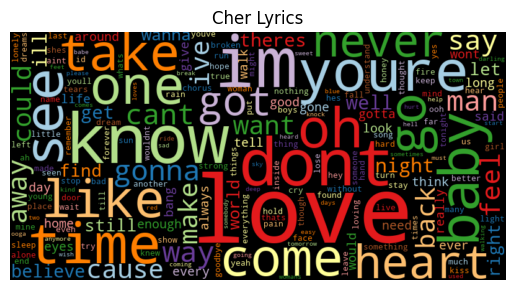

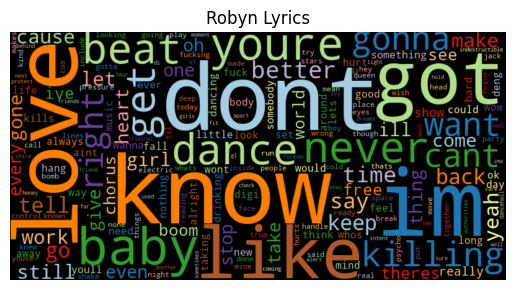

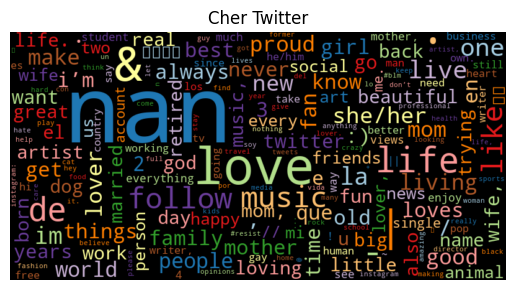

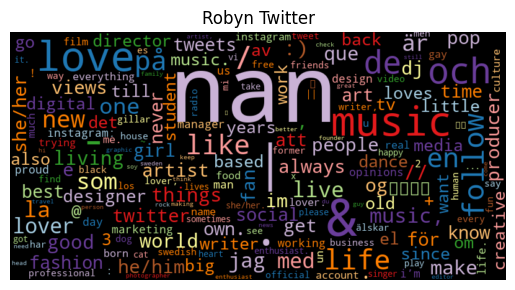

In [33]:
#Word Clouds

# Cher Lyrics
cher_lyrics_freq = count_words(lyrics_data[lyrics_data['artist'] == 'cher'])
wordcloud(cher_lyrics_freq['freq'], title="Cher Lyrics")
plt.show()

# Robyn Lyrics
robyn_lyrics_freq = count_words(lyrics_data[lyrics_data['artist'] == 'robyn'])
wordcloud(robyn_lyrics_freq['freq'], title="Robyn Lyrics")
plt.show()

# Cher Twitter
cher_twitter_freq = count_words(twitter_data[twitter_data['artist'] == 'cher'])
wordcloud(cher_twitter_freq['freq'], title="Cher Twitter")
plt.show()

# Robyn Twitter
robyn_twitter_freq = count_words(twitter_data[twitter_data['artist'] == 'robyn'])
wordcloud(robyn_twitter_freq['freq'], title="Robyn Twitter")
plt.show()


Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: First, it's important to note the presence of NAN in the twitter information. This displays the need for additional preprocessing before tokenizing. There must have been missing values in the twitter data that should have been removed or replaced with an empty string.  This will be noted for next time. Cher's lyrics are more romanitcal. Robyns, while still romance heavy are more related to dancing or moving suggesting a more up tempo type of genre. Cher's twitter is more political minded while Robyns are more emphasized for Sweden specifically. 